# Time Series Classification Algorithms - (1) Distance Based

<div style="border: 1px solid #007acc; background-color: #e6f4ff; padding: 10px; border-radius: 5px; color: black;">
  <strong>📘 Info:</strong> I do not claim ownership of the content in this notebook. It is based on official <a href="https://www.aeon-toolkit.org/en/latest/examples.html" target="_blank">aeon tutorials</a>, and parts of the code or text may have been copy-pasted or adapted directly from those or other sources for learning purposes.
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

from sklearn import metrics

import time

In [3]:
from aeon.datasets import load_classification
from aeon.distances import (
    dtw_alignment_path, dtw_distance,
    erp_alignment_path, erp_distance,
    lcss_alignment_path, lcss_distance,
    msm_alignment_path, msm_distance
)
from aeon.utils.discovery import all_estimators

# all_estimators("classifier", tag_filter={"algorithm_type": "distance"})

In [4]:
from aeon.classification.distance_based import (
    ElasticEnsemble,
    KNeighborsTimeSeriesClassifier,
    ProximityForest,
)

In [5]:
DATASET_NAMES = [
    "MelbournePedestrian",
    "ArrowHead",
    "Colposcopy"
]

X_train_dict, y_train_dict = {}, {}
X_test_dict, y_test_dict = {}, {}

accuracy_dict, f1_score_dict, duration_dict = {}, {}, {}

for dataset_name in DATASET_NAMES: 
    X_train_dict[dataset_name], y_train_dict[dataset_name] = load_classification(
        dataset_name, split="train"
    )
    X_test_dict[dataset_name], y_test_dict[dataset_name] = load_classification(
        dataset_name, split="test"
    )
    
    X_train_dict[dataset_name] = X_train_dict[dataset_name].squeeze(1)
    X_test_dict[dataset_name] = X_test_dict[dataset_name].squeeze(1)

    accuracy_dict[dataset_name] = {}
    f1_score_dict[dataset_name] = {}
    duration_dict[dataset_name] = {}

In [6]:
def plot_alignment_path(ts1, ts2, alignment_path, title, offset=2.0, max_lines=100):
    ts1 = np.array(ts1)
    ts2 = np.array(ts2)

    # Compute DTW alignment path
    path = alignment_path[0]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(ts1, label="Series 1", color="C0")
    ax.plot(ts2 + offset, label="Series 2 (offset)", color="C1")

    step = max(1, len(path) // max_lines)
    for i, j in path[::step]:
        ax.plot([i, j], [ts1[i], ts2[j] + offset], color='gray', alpha=0.5, lw=0.8)

    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

## 1. Elastic Distances

```bibtex
@inbook{faouzi2024,
  author = {Johann Faouzi},
  title = {Time Series Classification: A Review of Algorithms and Implementations},
  year = {2024},
  month = {March},
  booktitle = {Advances in Time Series Analysis and Forecasting},
  publisher = {IntechOpen},
  isbn = {978-0-85466-053-7},
  doi = {10.5772/intechopen.1004810},
}
```

"Although the Euclidean distance is the most common metric, it is not well suited to compare time series for two main reasons: (i) It is only defined for two vectors with the same length, whereas the time series of a given data set often have different lengths, and (ii) it compares the values of both time series at each time point independently, whereas the values of time series are correlated. Considering the minimum of the Euclidean distances between the smaller time series and the subsequences of the same length from the larger time series may not be optimal." \cite{faouzi2024}

### 1.1. Dynamic Time Warping (DTW)

```bibtex
@inproceedings{berndt1994,
  title = {Using Dynamic Time Warping to Find Patterns in Time Series},
  author = {Donald J. Berndt and James Clifford},
  booktitle = {KDD Workshop},
  year = {1994},
  url = {https://api.semanticscholar.org/CorpusID:929893}
}
```

Proposed by \cite{berndt1994}.

"Dynamic time warping (DTW) is a metric for time series that addresses both limitations of the Euclidean distance." \cite{faouzi2024}

Dynamic Time Warping is a powerful tool for analysing time series data, that was initially developed in the 1970’s to compare speech and word recognition with sound waves as a source. It offers a way to compare the similarity of time series data in ways that traditional methods might miss.

The main idea is to compute the distance from the matching of similar elements between time series. As an example, imagine two people saying the same sentence, one speaking quickly and one speaking more slowly. If you were to graph the sound waves of each sentence, the shapes would look similar in terms of rises and falls, but they would not line up perfectly all the time axis due to the difference in speak. If you tried to compare these sound waves using a straightforward, point-to-point approach (like Euclidean distance), the comparison would be unfair. It’s like trying to synchronize two singers when one is slightly ahead or behind the other; they’re singing the same notes, but not at the same time, so a direct comparison at any given moment wouldn’t make much sense.

https://medium.com/@markstent/dynamic-time-warping-a8c5027defb6

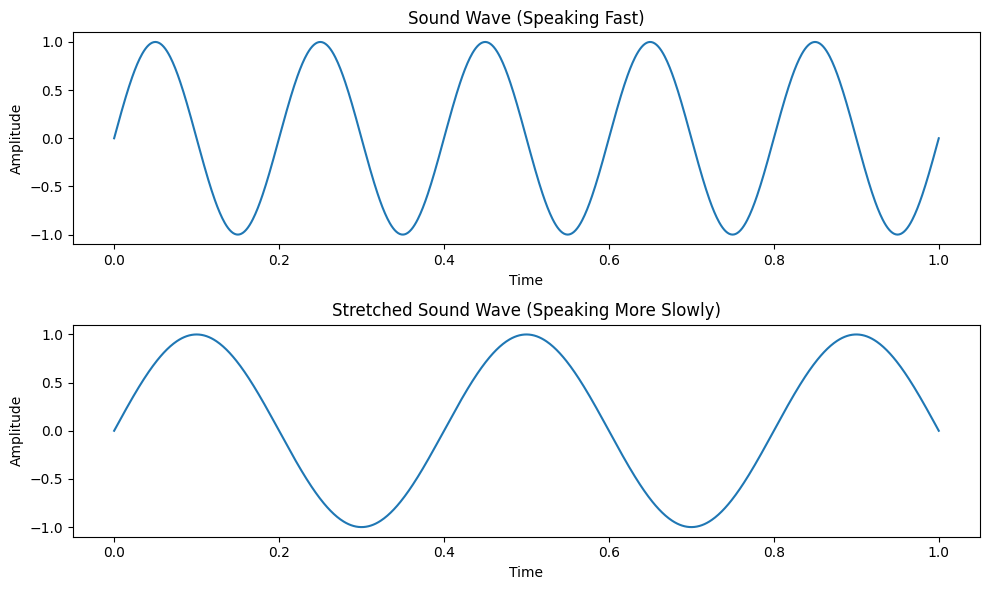

In [7]:
# Generating a simple sound wave as an example
t = np.linspace(0, 1, 1000)
sound_wave_fast = np.sin(2 * np.pi * 5 * t)  # 5 Hz tone

# Stretching the sound wave to simulate speaking more slowly
# We'll simulate this by reducing the frequency
sound_wave_slow = np.sin(2 * np.pi * 2.5 * t)  # 2.5 Hz tone, half the original frequency

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plotting the fast speaking sound wave
axs[0].plot(t, sound_wave_fast)
axs[0].set_title('Sound Wave (Speaking Fast)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

# Plotting the stretched sound wave (speaking more slowly)
axs[1].plot(t, sound_wave_slow)
axs[1].set_title('Stretched Sound Wave (Speaking More Slowly)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

At first glance, its not easy to compare the above two graphs or their similariy. DTW is perfect for this, it stretches and compresses the time axes of the sound waves to find the best possible alignment between them.

Imagine grabbing the wave of the faster speaker and stetching it out so that the syllables and pauses match up. Dynamic time warping effectively ‘warps’ the data to make sure each point in one series is matched with the most relevant points in the other series, regardless of their position in time. This makes it great for a whole host of applications.

Let us now illustrate the typical behavior of alignment-based metrics with an example.

Comparison between DTW and Euclidean distance. Note that, for the sake of visualization, time series are shifted vertically, but one should imagine that feature value ranges (y-axis values) match:

<img src="images/01_dtw.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

Note how DTW matches distinctive patterns of the time series, which is likely to result in a more sound similarity assessment than when using Euclidean distance that matches timestamps regardless of the feature values.

https://rtavenar.github.io/blog/dtw.html

Let us consider two time series $x$ and $x'$ of respective lengths $n$ and $m$. Here, all elements $x_i$ and $x'_j$ are assumed to lie in the same p-dimensional space and the exact timestamps at which observations occur are disregarded: only their ordering matters.

Dynamic Time Warping seeks for the temporal alignment that minimizes Euclidean distance between aligned series.

More formally, the optimization problem writes:

<img src="images/01_dtw2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

Another way to represent a DTW path is to use a binary matrix whose non-zero entries are those corresponding to a matching between time series elements. This representation is related to the index sequence representation used above through:

<img src="images/01_dtw3.png" style="width:300px; border: 1px solid #ccc; border-radius: 5px;">

This is illustrated in the Figure below where nonzero entries in the binary matrix are represented as dots and the equivalent sequence of matchings is produced on the right:

<img src="images/01_dtw4.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

Using matrix notation, Dynamic Time Warping can be written as the minimization of a dot product between matrices:

<img src="images/01_dtw5.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">


DTW can be solved with Dynamic Programming:

```python
def dtw(x, x_prime, q=2):
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = d(x[i], x_prime[j]) ** q
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else inf,
          R[i  , j-1] if j > 0             else inf,
          R[i-1, j-1] if (i > 0 and j > 0) else inf
          # Note that these 3 terms cannot all be
          # inf if we have (i > 0 or j > 0)
        )

  return R[-1, -1] ** (1. / q)
```

**Recommended videos:**
- https://www.youtube.com/watch?v=ERKDHZyZDwA
- https://www.youtube.com/watch?v=9GdbMc4CEhE

"Despite its advantages over the Euclidean distance to compare time series, dynamic time warping has several important limitations. First, its algorithmic complexity is $O(nm)$, where n and m are the lengths of both time series, which is high. Second, it is not a distance because it does not satisfy not only the separation property (the DTW score between two different time series can be zero) but more importantly the triangle inequality, meaning that efficient nearest-neighbor search algorithms such as the K-dimensional tree and the ball tree structures cannot be used. Third, DTW allows for very large time warps, which may be undesired. Fourth, DTW is not differentiable, making it difficult to use with machine learning algorithms that rely on minimizing an objective function with gradient descent or a variant thereof. Several variants of DTW have been proposed to address one or several limitations of its original version. A common approach consists in limiting the time warps by using a constraint region: The set of warping paths is restricted to the set of warping paths such that all their elements belong to the constraint region. This approach also decreases the computational complexity of the cost and accumulated cost matrices since only the entries belonging to the constraint region have to be computed, but adds the computational cost of the constraint region. Two commonly used constraint regions are the Sakoe-Chiba band and the Itakura parallelogram. The Sakoe-Chiba band limits the time warps to be no greater than half the bandwidth, while the Itakura parallelogram limits the time warps to be no greater than a variable value, this value being larger in the middle of the time series than at the starting and ending time points. \cite{faouzi2024}"

In [8]:
dtw_distance(sound_wave_fast, sound_wave_slow)

249.78207344646475

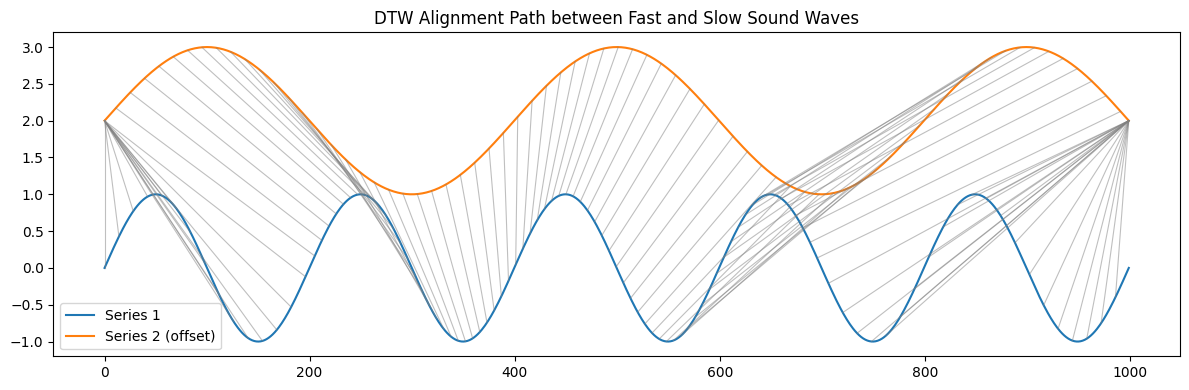

In [9]:
dtw_a_path = dtw_alignment_path(sound_wave_fast, sound_wave_slow)
plot_alignment_path(
    sound_wave_fast,
    sound_wave_slow,
    dtw_a_path,
    title="DTW Alignment Path between Fast and Slow Sound Waves",
)

### 1.2. Edit Real Penalty (ERP)

```bibtex
@inproceedings{chen2004,
  author = {Chen, Lei and Ng, Raymond},
  title = {On the marriage of Lp-norms and edit distance},
  year = {2004},
  isbn = {0120884690},
  publisher = {VLDB Endowment},
  booktitle = {Proceedings of the Thirtieth International Conference on Very Large Data Bases},
  volume = {30},
  pages = {792-–803},
  series = {VLDB '04}
}
```

Proposed by \cite{chen2004}.

Unlike other edit based distances included in this package, this distance is a metric and fulfills the triangle inequality.

The idea is to search for the minimal path in a distance matrix that describes the mapping between the two series. This distance matrix is built by using the Euclidean distance. However, unlike DTW, this distance permits gaps or sequences of points that are not matched with any other point. These gaps will be penalized based on the distance of the unmatched points from a reference value $g$.

As with other edit based distances, the length of $x$ and $y$ may be different.

https://search.r-project.org/CRAN/refmans/TSdist/html/ERPDistance.html

Edit Distance with Real Penalty, ERP, attempts to align time series by better considering how indexes are carried forward through the cost matrix. Usually in the DTW cost matrix, if an alignment cannot be found the previous value is carried forward in the move off the diagonal. ERP instead proposes the idea of gaps or sequences of points that have no matches. These gaps are then penalised based on their distance from the parameter.

https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.erp_distance.html

In [10]:
erp_distance(sound_wave_fast, sound_wave_slow)

456.0990136734519

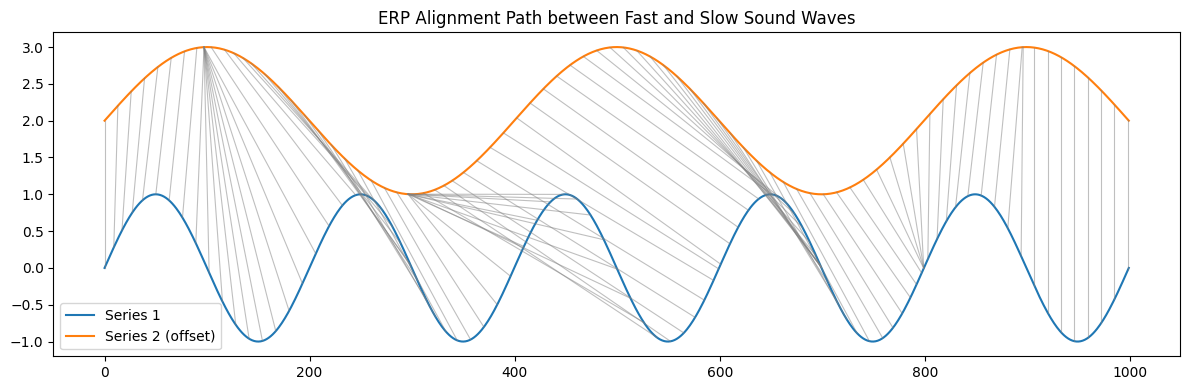

In [11]:
erp_a_path = erp_alignment_path(sound_wave_fast, sound_wave_slow)
plot_alignment_path(
    sound_wave_fast,
    sound_wave_slow,
    erp_a_path,
    title="ERP Alignment Path between Fast and Slow Sound Waves",
)

### 1.3. Move-Split-Merge (MSM)

```bibtex
@article{stefan2013,
  author = {Stefan, Alexandra and Athitsos, Vassilis and Das, Gautam},
  journal = {IEEE Transactions on Knowledge and Data Engineering}, 
  title = {The Move-Split-Merge Metric for Time Series}, 
  year = {2013},
  volume = {25},
  number = {6},
  pages = {1425--1438},
  doi = {10.1109/TKDE.2012.88}
}
```

Proposed by \cite{stefan2013}.

"A novel metric for time series, called Move-Split-Merge (MSM), is proposed. This metric uses as building blocks three fundamental operations: Move, Split, and Merge, which can be applied in sequence to transform any time series into any other time series. A Move operation changes the value of a single element, a Split operation converts a single element into two consecutive elements, and a Merge operation merges two consecutive elements into one. Each operation has an associated cost, and the MSM distance between two time series is defined to be the cost of the cheapest sequence of operations that transforms the first time series into the second one. An efficient, quadratic-time algorithm is provided for computing the MSM distance. MSM has the desirable properties of being metric, in contrast to the Dynamic Time Warping (DTW) distance, and invariant to the choice of origin, in contrast to the Edit Distance with Real Penalty (ERP) metric. At the same time, experiments with public time series data sets demonstrate that MSM is a meaningful distance measure, that oftentimes leads to lower nearest neighbor classification error rate compared to DTW and ERP." \cite{stefan2013}

- DTW uses distance between two points on insert/delete.
- ERP uses distance to a constant on insert/delete
- MSM combines these

https://www.youtube.com/watch?v=O5cnKAUBKkg

In [12]:
msm_distance(sound_wave_fast, sound_wave_slow)

675.2971438967166

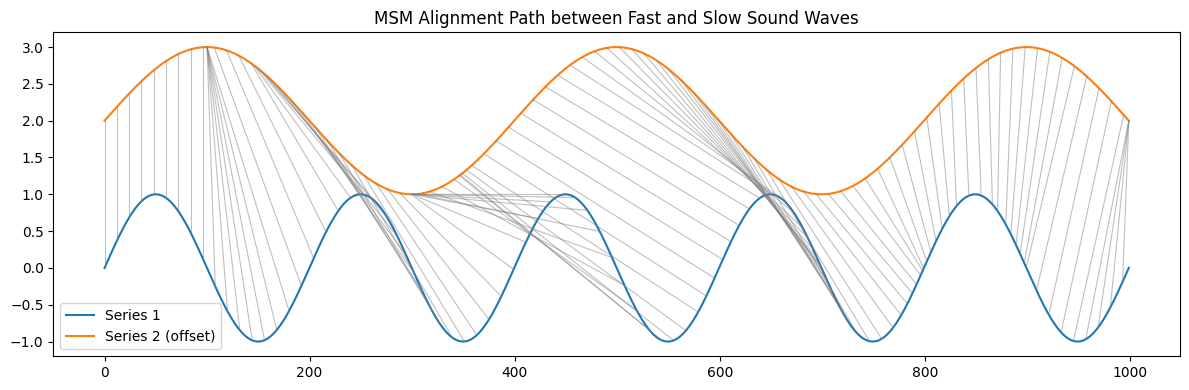

In [13]:
msm_a_path = msm_alignment_path(sound_wave_fast, sound_wave_slow)
plot_alignment_path(
    sound_wave_fast,
    sound_wave_slow,
    msm_a_path,
    title="MSM Alignment Path between Fast and Slow Sound Waves",
)

### 1.4. Longest Common Subsequence (LCSS)

```bibtex
@inproceedings{vlachos2002,
  author = {Vlachos, Michalis and Kollios, George and Gunopulos, Dimitrios},
  year = {2002},
  month = {02},
  pages = {673--684},
  title = {Discovering similar multidimensional trajectories},
  isbn = {0-7695-1531-2},
  journal = {Proceedings - International Conference on Data Engineering},
  doi = {10.1109/ICDE.2002.994784}
}
```

Proposed by \cite{vlachos2002}.

The LCSS distance for time series is based on the solution to the longest common subsequence problem in pattern matching. The typical problem is to find the longest subsequence that is common to two discrete series based on the edit distance. This approach can be extended to consider real-valued time series by using a distance threshold epsilon, which defines the maximum difference between a pair of values that is allowed for them to be considered a match. LCSS finds the optimal alignment between two series by find the greatest number of matching pairs. The LCSS distance uses a matrix Lthat records the sequence of matches over valid warpings. For two series $a = a_1, ..., a_n$ and $b = b_1, ..., b_n$, $L'$ is found by iterating over all valid windows (i.e. where bounding_matrix is not infinity). Note that series a and b need not be equal length.

LCSS attempts to find the longest common sequence between two time series and returns a value that is the percentage that longest common sequence assumes. The value returned will be between 0.0 and 1.0, where 0.0 means the two time series are exactly the same and 1.0 means they are complete opposites.

https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.distances.lcss_distance.html#aeon.distances.lcss_distance

In [14]:
lcss_distance(sound_wave_fast, sound_wave_slow)

0.235

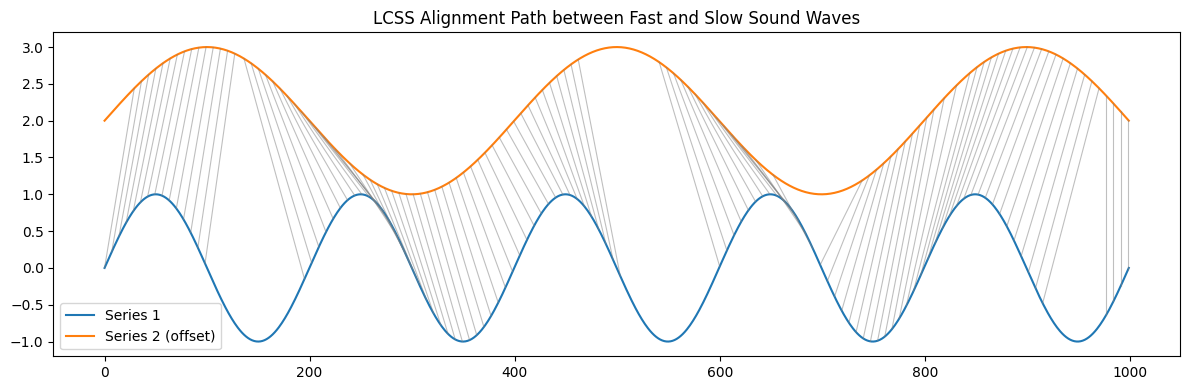

In [15]:
lcss_a_path = lcss_alignment_path(sound_wave_fast, sound_wave_slow)
plot_alignment_path(
    sound_wave_fast,
    sound_wave_slow,
    lcss_a_path,
    title="LCSS Alignment Path between Fast and Slow Sound Waves",
)

## 2. K-NN: KNeighbors

k-NN is often called a lazy classifier, because there is little work done in the fit operation. The fit operation simply stores the training data. When we want to make a prediction for a new time series, k-NN measures the distance between the new time series and all the series in the training data and records the class of the closest k train series. The class labels of these nearest neighbours are used to make a prediction: if they are all the same label, then that is the prediction. If they differ, then some form of voting mechanism is required. For example, we may predict the most common class label amongst the nearest neighbours for the test instance.

https://www.aeon-toolkit.org/en/latest/examples/classification/distance_based.html

In [16]:
N_NEIGHBOURS = 3

In [17]:
method = "KNN with DTW"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    knn_dtw = KNeighborsTimeSeriesClassifier(distance="dtw", n_neighbors=N_NEIGHBOURS)
    knn_dtw.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    knn_dtw_preds = knn_dtw.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], knn_dtw_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], knn_dtw_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

KNN with DTW
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.88
F1-Score: 0.88
Duration: 5.90 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.71
F1-Score: 0.71
Duration: 1.54 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.34
F1-Score: 0.33
Duration: 1.13 seconds


In [18]:
method = "KNN with MSM"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    knn_msm = KNeighborsTimeSeriesClassifier(distance="msm", n_neighbors=N_NEIGHBOURS)
    knn_msm.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    knn_msm_preds = knn_msm.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], knn_msm_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], knn_msm_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

KNN with MSM
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.88
F1-Score: 0.88
Duration: 122.32 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.75
F1-Score: 0.75
Duration: 3.10 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.28
F1-Score: 0.28
Duration: 2.41 seconds


In [19]:
method = "KNN with ERP"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    knn_erp = KNeighborsTimeSeriesClassifier(distance="erp", n_neighbors=N_NEIGHBOURS)
    knn_erp.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    knn_erp_preds = knn_erp.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], knn_erp_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], knn_erp_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

KNN with ERP
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.95
F1-Score: 0.95
Duration: 7.95 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.77
F1-Score: 0.77
Duration: 1.39 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.28
F1-Score: 0.27
Duration: 1.09 seconds


In [20]:
method = "KNN with LCSS"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    knn_lcss = KNeighborsTimeSeriesClassifier(distance="lcss", n_neighbors=N_NEIGHBOURS)
    knn_lcss.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    knn_lcss_preds = knn_lcss.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], knn_lcss_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], knn_lcss_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

KNN with LCSS
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.33
F1-Score: 0.32
Duration: 93.31 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.39
F1-Score: 0.34
Duration: 1.38 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.29
F1-Score: 0.28
Duration: 1.27 seconds


## 3. Elastic Ensemble

```bibtex
@article{lines2015,
  author = {Jason Lines and Anthony Bagnall},
  title = {Time series classification with ensembles of elastic distance measures},
  journal = {Data Mining and Knowledge Discovery},
  volume = {29},
  number = {3},
  pages = {565--592},
  year = {2015},
  doi = {10.1007/s10618-014-0361-2},
  url = {https://doi.org/10.1007/s10618-014-0361-2},
  issn = {1573-756X},
}
```

Proposed by \cite{lines2015}.

The first algorithm to significantly out perform 1-NN DTW on the UCR data was the Elastic Ensemble (EE). EE is a weighted ensemble of 11 1-NN classifiers with a range of elastic distance measures. It was the best performing distance based classifier in the original bake off. Elastic distances can be slow, and EE requires cross validation to find the weights of each classifier in the ensemble. You can configure EE to use specified distance functions, and tell it how much.

https://www.aeon-toolkit.org/en/latest/examples/classification/distance_based.html

```bibtex
@inproceedings{lines2022,
  author = {Lines, Jason and Oastler, George},
  title = {TS-QUAD: A Smaller Elastic Ensemble for Time Series Classification with No Reduction in Accuracy},
  booktitle = {Pattern Recognition and Artificial Intelligence},
  year = {2022},
  publisher = {Springer International Publishing},
  pages = {221--232},
  isbn = {978-3-031-09282-4},
  url = {https://link.springer.com/chapter/10.1007/978-3-031-09282-4_19}
}
```
"The Elastic Ensemble (EE) is a time series classification (TSC) ensemble that includes eleven nearest neighbour (NN) classifiers that use variations of eight elastic distance measures. While EE offers an accurate solution for TSC in the time domain, its relatively slow run-time is a weakness." \cite{lines2022}

In [21]:
method = "ElasticEnsemble"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    ee = ElasticEnsemble(
        distance_measures=["dtw", "msm"],
        proportion_of_param_options=0.1,
        proportion_train_in_param_finding=0.3,
        proportion_train_for_test=0.5
    )
    ee.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    ee_preds = ee.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], ee_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], ee_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

ElasticEnsemble
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.95
F1-Score: 0.95
Duration: 25.53 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.73
F1-Score: 0.72
Duration: 3.43 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.24
F1-Score: 0.24
Duration: 8.02 seconds


## 4. Proximity Forest

```bibtex
@article{lucas2019,
   title={Proximity Forest: an effective and scalable distance-based classifier for time series},
   volume={33},
   issn={1573-756X},
   url={http://dx.doi.org/10.1007/s10618-019-00617-3},
   doi={10.1007/s10618-019-00617-3},
   number={3},
   journal={Data Mining and Knowledge Discovery},
   publisher={Springer Science and Business Media LLC},
   author={Lucas, Benjamin and Shifaz, Ahmed and Pelletier, Charlotte and O’Neill, Lachlan and Zaidi, Nayyar and Goethals, Bart and Petitjean, François and Webb, Geoffrey I.},
}
```

Proposed by \cite{lucas2019}.

"In contrast to the time series forest and time series bag-of-features algorithms that rely on extracting features from time series and then build a random forest, the proximity forest algorithm works directly with raw time series and is inspired by the extremely randomized trees algorithm. To better understand the proximity forest algorithm, we briefly recall the main concepts of the extremely randomized trees algorithm. Like in a random forest, several trees are independently trained. The major difference between both algorithms comes from the splitting criterion used to split a node into child nodes. In a random forest, only a random subset of the features is considered, and the best (feature, threshold) pair is chosen over all the possible (feature, threshold) pairs. In extremely randomized trees, randomness goes one step further: Instead of considering all the possible thresholds for each feature from the random subset of features, a single threshold is randomly generated for each feature, and the best (feature, threshold) pair is chosen. The node splitting process is thus much faster in extremely randomized trees since much fewer (feature, threshold) pairs are considered. Another consequence is that a single tree from extremely randomized trees usually performs worse than a single tree in a random forest, but the extremely randomized trees are less correlated than the trees of a random forest, thus benefitting more from averaging the predictions of each tree. Because the trees of the proximity forest tend not to be highly correlated, the proximity forest benefits from aggregating the predictions of each tree by decreasing the variance of the final model and has proven to give a good predictive performance on average." \cite{faouzi2024}

```bibtex
@article{middlehurst2024,
  author = {Middlehurst, Matthew and Sch{\"a}fer, Patrick and Bagnall, Anthony},
  title = {Bake Off Redux: A Review and Experimental Evaluation of Recent Time Series Classification Algorithms},
  journal = {Data Mining and Knowledge Discovery},
  volume = {38},
  pages = {1958--2031},
  year = {2024},
  doi = {10.1007/s10618-024-01022-1},
  url = {https://doi.org/10.1007/s10618-024-01022-1}
}
```

It creates an ensemble of decision trees, where the splits are based on the similarity between time series measured using various parameterised distance measures. The current algorithm is implemented to work for univariate, equal-length time-series data.

It was the best performing algorithm in the 2024 bakeoff \cite{middlehurst2024}.

https://www.aeon-toolkit.org/en/latest/examples/classification/distance_based.html

"Typical decision trees branch on the value of an attribute. Treating the values at each time stamp as belonging to a single attribute does not work well on time series because the relevant signals are not necessarily aligned by time stamp. Instead, Proximity Forest branches on the proximity of a query time series to a set of reference series. ‘Proximity’ is defined by a given (time series) similarity measure and a set of parameters (most time series measures have parameters that are critical to their proper function). Our trees define separating hyperplanes for which the position is supported by time series themselves (whereas a traditional tree would split using a threshold on the value of an attribute). Proximity Forest, as opposed to nearest neighbour approaches, truly abstracts a model from data, which makes it possible to classify with time that is logarithmic with respect to training set size, as opposed to linear time for EE and COTE."
"A Proximity Tree is similar to a regular decision tree, but differs in the tests applied at internal nodes. Whereas a regular decision tree applies a test based on the value of an attribute (e.g. if height > 160 cm, follow the left branch, otherwise follow the right branch), each branch of an internal node of a Proximity Tree has an associated exemplar and an object follows the branch corresponding to the exemplar to which it is closest according to a parameterized similarity measure."
"An internal node has two fields, measure, a function object × object → R, and branches, a vector of branches. Each branch has two fields, a time series (exemplar) and a tree to which an object is passed if it is nearer to the branch’s exemplar than any other (subtree). If all data reaching a node has the same class, i.e. is pure, the create_leaf function creates a new leaf node and assigns this class label to its field class. This label is then assigned to any query time series reaching this leaf during the testing phase."
"How do we choose the splitting criteria? A Proximity Tree creates, at each node, one branch for each class that exists in the data it receives from its parent. These exemplars are chosen uniformly at random among each class. The parameterized similarity measures are also chosen uniformly at random among a pool"
"Algorithm 1 presents the algorithm for learning a single tree. Each node is constructed recursively from the root node down to the leaves. If the data at the node is pure– ie. all data belongs to the same class– then the node becomes a leaf and the recursion finishes."

<img src="images/01_pforest.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

"At each node, a pool of r candidate splits are evaluated (Algorithm 2). For each candidate, a parameterised measure is chosen uniformly at random among a pool of such measures. We then select an exemplar for each class represented at the node and pass the data down the branches by finding the closest exemplar (one per class) for each time series in the data using the split’s distance measure. Once each candidate split has been created, we then select the candidate that maximizes the difference between the Gini impurity of the parent node and the weighted sum of Gini impurity of the child nodes. We then call the construction of the tree recursively on each branch for the successful candidate; this constructs all subtrees. When this is done, the tree is constructed."

<img src="images/01_pforest2.png" style="width:600px; border: 1px solid #ccc; border-radius: 5px;">

"The parametrised distance measure gives a measure of the similarity between the exemplar time series. For each candidate split at each node, the algorithm chooses a distance measure at random from the following 11 distance measures used by the Elastic Ensemble (EE) learner that we described above: Euclidean Distance (ED); Dynamic Time Warping using the full window (DTW); Dynamic Time Warping with a restricted warping window (DTW-R); Weighted Dynamic Time Warping (WDTW); Derivative Dynamic Time Warping using the full window (DDTW); Derivative Dynamic Time Warping with a restricted warping window (DDTW-R); Weighted Derivative Dynamic Time Warping (WDDTW); Longest Common Subsequence (LCSS); Edit Distance with Real Penalty (ERP); Time Warp Edit Distance (TWE); and, Move-Split-Merge (MSM). Randomising the choice of distance measure is a deliberate decision to introduce variability between each tree, for the reasons stated earlier." \cite{lucas2019}

In [22]:
method = "ProximityForest"
print(method)

for dataset_name in DATASET_NAMES:
    start_time = time.time()

    p_forest = ProximityForest(n_trees=20, n_splitters=5, max_depth=10)
    p_forest.fit(X_train_dict[dataset_name], y_train_dict[dataset_name])
    p_forest_preds = p_forest.predict(X_test_dict[dataset_name])
    accuracy_dict[dataset_name][method] = metrics.accuracy_score(
        y_test_dict[dataset_name], p_forest_preds
    )
    f1_score_dict[dataset_name][method] = metrics.f1_score(
        y_test_dict[dataset_name], p_forest_preds,
        average="weighted"
    )

    elapsed_time = time.time() - start_time
    duration_dict[dataset_name][method] = elapsed_time
    print("-------------------------------------------")
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy_dict[dataset_name][method]:.2f}")
    print(f"F1-Score: {f1_score_dict[dataset_name][method]:.2f}")
    print(f"Duration: {duration_dict[dataset_name][method]:.2f} seconds")

ProximityForest
-------------------------------------------
Dataset: MelbournePedestrian
Accuracy: 0.96
F1-Score: 0.96
Duration: 8.55 seconds
-------------------------------------------
Dataset: ArrowHead
Accuracy: 0.87
F1-Score: 0.87
Duration: 9.79 seconds
-------------------------------------------
Dataset: Colposcopy
Accuracy: 0.24
F1-Score: 0.24
Duration: 16.86 seconds


## 5. Comparison between the Classifiers

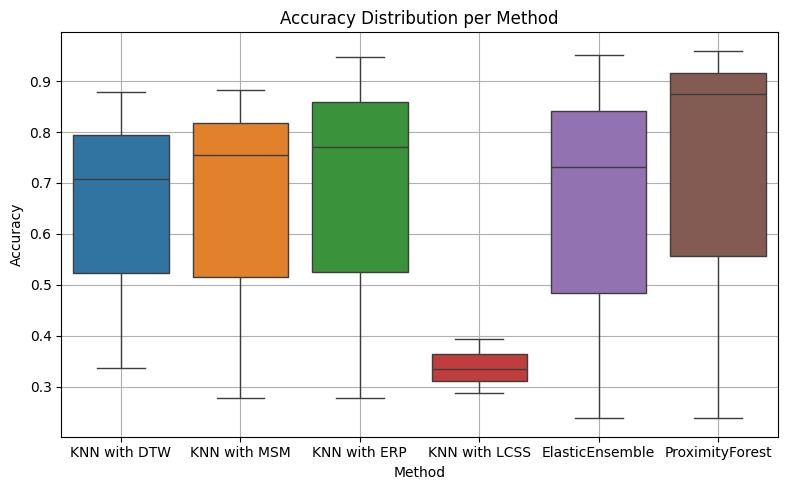

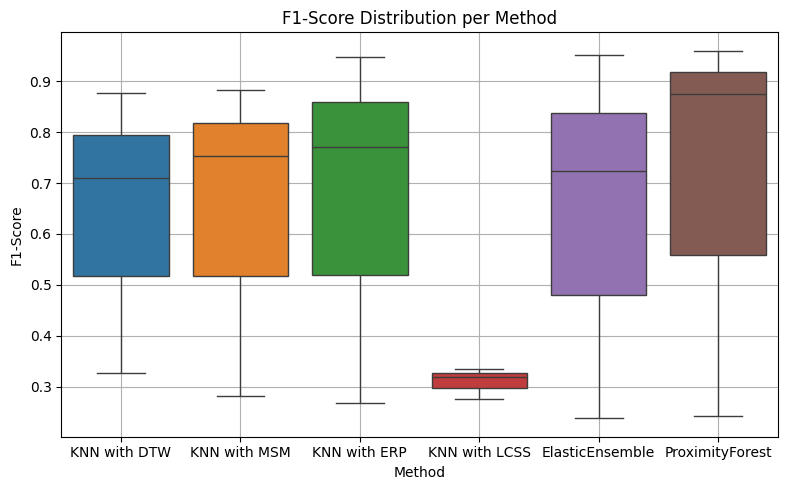

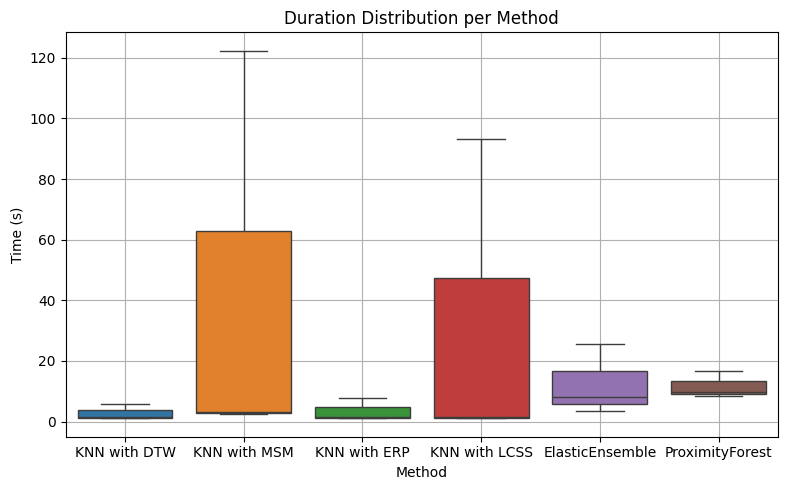

In [23]:
datasets = list(accuracy_dict.keys())
methods = list(next(iter(accuracy_dict.values())).keys())

def prepare_long_format(metric_dict, metric_name):
    records = []
    for ds in datasets:
        for method in methods:
            val = metric_dict[ds][method]
            if isinstance(val, (int, float)):
                records.append({
                    "Dataset": ds,
                    "Method": method,
                    "Metric": float(val),
                    "Type": metric_name
                })
    return pd.DataFrame(records)

df_accuracy = prepare_long_format(accuracy_dict, "Accuracy")
df_f1 = prepare_long_format(f1_score_dict, "F1-Score")
df_duration = prepare_long_format(duration_dict, "Duration (s)")

df_all = pd.concat([df_accuracy, df_f1, df_duration], ignore_index=True)

def plot_boxplot(df, title, ylabel):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="Method", y="Metric", hue="Method")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Method")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_boxplot(df_accuracy, "Accuracy Distribution per Method", "Accuracy")
plot_boxplot(df_f1, "F1-Score Distribution per Method", "F1-Score")
plot_boxplot(df_duration, "Duration Distribution per Method", "Time (s)")